In [13]:
%matplotlib inline

# COVID-19 Моделирование распространения и анализ

Целью данной лабораторной является построение модели заболевания населения COVID-19, обладающей как можно лучшей предсказательной силой. Каждый студент может на свое усмотрение выбрать факторы, учитываемой моделью, по результатам семестра проводится конкурс на лучшую модель. 

### Ход выполнения работы

1. Изучение теории и имеющихся данных. 

1. Формулировка гипотез о связах величин и законах их изменения.

1. Построение математической модели, нахождение аналитических решений, написание кода для симуляции.

1. Качественное сравнение результатов модели и реальных данных.

1. Оценивание параметров модели на основе реальных данных. 

1. Количественное сравнение предсказаний модели с историческими данными.

1. Извелечение практически полезной информации, например, оценка продолжительности болезни, [индекса репродукции](https://ru.wikipedia.org/wiki/Индекс_репродукции), скорости снижения иммунитета, тенденции изменения этих параметров, формирование сценариев дальнейшего развития ситуации с COVID-19.

1. Предложения по добавлению управляющих параметров, таких как введение каратнинов, и разработка алгоритма, позволяющего добиться контроля над распространением ковида.  

## Исходные данные по COVID-19

1. [COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19) [Визуализация данных](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6)

1. [Kouprianov, A. (2021). COVID-19.SPb.monitoring. Monitoring COVID-19 epidemic in St. Petersburg, Russia: Data and scripts.](https://github.com/alexei-kouprianov/COVID-19.SPb.monitoring) [Данные по всей России.](https://github.com/alexei-kouprianov/COVID.2019.ru/)

1. [Coronavirus (Covid-19) Data in the United States](https://github.com/nytimes/covid-19-data)

1. [Our World in Data](https://github.com/owid/covid-19-data) Данные по избыточной смертности по месяцам. [Визуализация данных](https://ourworldindata.org/coronavirus)

1. [Oxford Covid-19 Government Response Tracker](https://github.com/OxCGRT/covid-policy-tracker)

1. [Яндекс. Коронавирус: дашборд](https://datalens.yandex/7o7is1q6ikh23?tab=X1&utm_source=cbmain) [Данные на карте.](https://yandex.ru/maps/covid19?ll=41.775580%2C54.894027&z=3)

1. [Excess mortality during the COVID-19 pandemic](https://github.com/dkobak/excess-mortality)

## Публикации про данные

1. [Что важно знать гражданам Санкт-Петербурга об эпидемии коронавируса.](https://github.com/alexei-kouprianov/COVID-19.SPb.monitoring/blob/main/texts/SPb.COVID-19.overview.md) [COVID-19 в Петербурге, сводный инфографический отчет.](https://github.com/alexei-kouprianov/COVID-19.SPb.monitoring/blob/main/texts/SPb.COVID-19.r_report.md) [Фонтанка: Волна идет на подъем? О чем молчит официальная ковидная статистика в Петербурге](https://www.fontanka.ru/2021/09/08/70123958/)

## Данные о возрастной пирамиде

1. [PopulationPyramid.net](https://www.populationpyramid.net/ru/%D1%80%D0%BE%D1%81%D1%81%D0%B8%D1%8F/2020/)

1. [Росстат: Численность населения Российской Федерации по муниципальным образованиям](https://rosstat.gov.ru/compendium/document/13282)

In [1]:
# Устанавливаем библиотеки, если это не было сделано ранее.
# ! pip3 install seaborn matplotlib numpy pandas

In [27]:
# Импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
import seaborn as sns

# Используем настройки seaborn по-умолчанию, устанавливаем только размер рисунка
sns.set(rc={'figure.figsize':(11, 4)})

In [6]:
# Загрузка данных агрегированных А. Куприяновым.
# URL = 'https://raw.githubusercontent.com/alexei-kouprianov/COVID-19.SPb.monitoring/main/data/SPb.COVID-19.united.csv'
# urllib.request.urlretrieve(URL, 'data/SPb.COVID-19.united.csv')

In [7]:
# Читаем локальную копию файла
data = pd.read_csv('data/SPb.COVID-19.united.csv', na_values='NA', parse_dates=[0,5], index_col=0)
# Выводим названия столбцов и типы
print(data.dtypes)
# Выводим размер таблицы
print(data.shape)

CONFIRMED.sk                                  int64
RECOVERED.sk                                  int64
DEATHS.sk                                     int64
ACTIVE.sk                                     int64
DATE.spb                             datetime64[ns]
CONFIRMED.spb                               float64
RECOVERED.spb                               float64
ACTIVE.spb                                  float64
IN_HOSPITALS.spb                            float64
HOSPITALIZED_TODAY.spb                      float64
PCR_TESTS                                   float64
V1.CS                                       float64
V1.TODAY                                    float64
V2.CS                                       float64
V2.TODAY                                    float64
V.REMAINING                                 float64
DESIGNATED_BEDS                             float64
VENT                                        float64
VR1.CS                                      float64
VR1.TODAY   

In [8]:
# Визуально проверяем корректность загруженных данных
# data

Так как имеющиеся данные описывают только изменение численности больших классов людей, то анализ этих данных будем проводить в духе [SIR модели](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology).
Всех людей мы объединяем в классы: S - восприимчивые к болезни, I - зараженные/болеющие, R - невосприимчивые к болезни/выздоровевшие/погибшие. 
Число больных I доступно в инсторических данных непосредственно в поле `ACTIVE.sk`, все данные приводятся с шагом в день. Числа S и R непосредственно не доступны, однако у нас есть данные о переходах между классами: 
- Поле `CONFIRMED.sk` содержит число заболевших, т.е. перешедших из класса S в класс I. 
- Поле `RECOVERED.sk` содержит число выздоровевших, а поле `DEATHS.sk` число погибших. Их сумма равна числу перешедших из класса I в класс R.

Значение `ACTIVE.sk` теоретически можно вычислить через поля `CONFIRMED.sk`, `RECOVERED.sk`, `DEATH.sk`, практически же сохраненные значения и вычисленные могут немного различаться. 

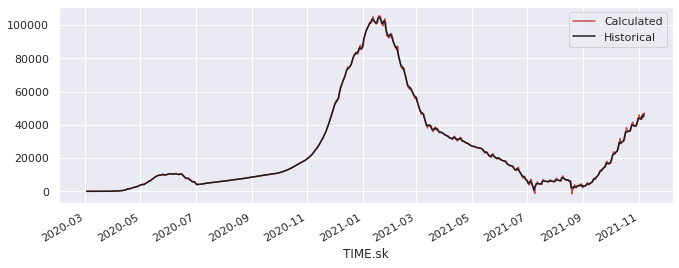

In [30]:
(data['ACTIVE.sk']+data['CONFIRMED.sk']-data['RECOVERED.sk']-data['DEATHS.sk']).plot(style='-r', label='Calculated')
(data['ACTIVE.sk'].shift(-1)).plot(style='k', label='Historical')
plt.legend()
plt.show()

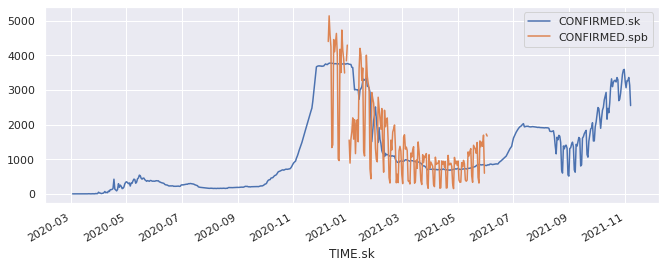

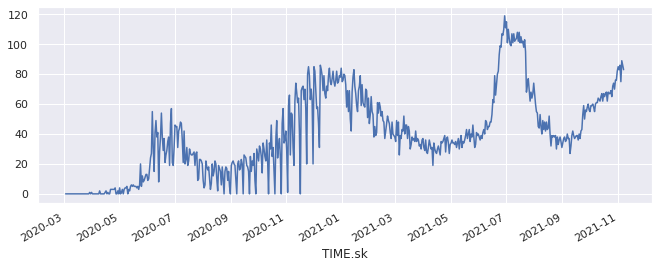

In [31]:
# Посмотрим, как изменялись число заражений и число смертей.
data[['CONFIRMED.sk','CONFIRMED.spb']].plot(subplots=False)
plt.show()

data['DEATHS.sk'].plot(subplots=True)
plt.show()


In [32]:
# Мы видим колебания статистики в течении недели, возникающие из-за особенностей сбора данных.
# Просуммируем данные за каждую неделю, что уменьшит шум.

data7 = data.resample('7D').sum()

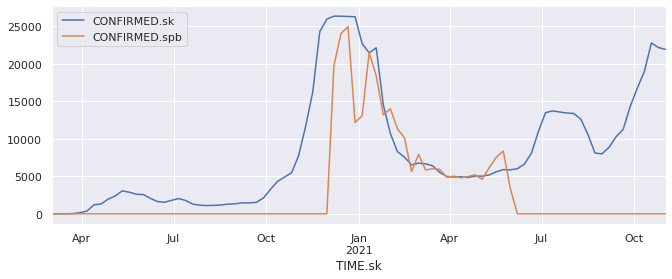

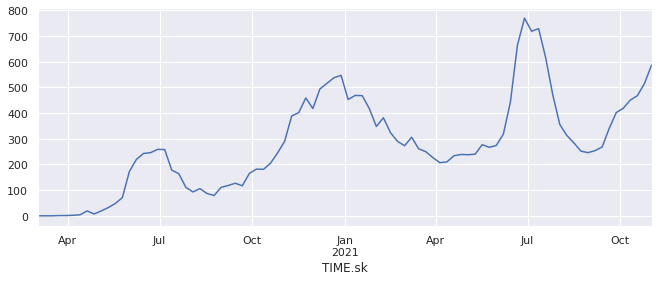

In [33]:
data7[["CONFIRMED.sk","CONFIRMED.spb"]].plot(subplots=False)
plt.show()
data7["DEATHS.sk"].plot(subplots=False)
plt.show()

В имеющихся у нас данных нет переходов из класса R в класс S, что соответствует потере иммунитета со временем.
По оценкам иммунологов иммунитет должен сохраняться хотя бы в течении 6 месяцев, причем иммуный человек заболевает со значительно меньшей вероятностью, поэтому во время первой волны заболеваний ковидом переходами R -> S можно пренебречь. 

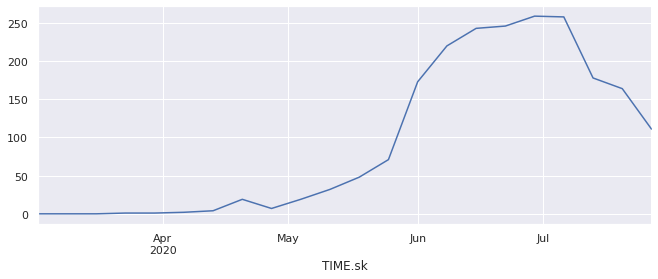

In [41]:
# Извлечем данные по первой полне
first_wave = data7.loc[:'2020-08-01']

# Проверим визуально, что данные по смертям действительно показывают одну волну.
first_wave['DEATHS.sk'].plot()
plt.show()

[SIR модель](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model_without_vital_dynamics) описывается системой дифференциальных уравнений:
$$
\begin{cases}
\frac{dS}{dt} = -\frac{\beta I S}{N},\\
\frac{dI}{dt} = \frac{\beta I S}{N}-\gamma I,\\
\frac{dR}{dt} = \gamma I. 
\end{cases}
$$

Полное число людей $N=S+I+R$ в этой модели постоянно.
По данным Росстат население Петербурга на 1 января 2021 составило $N=5 384 342$ человек.

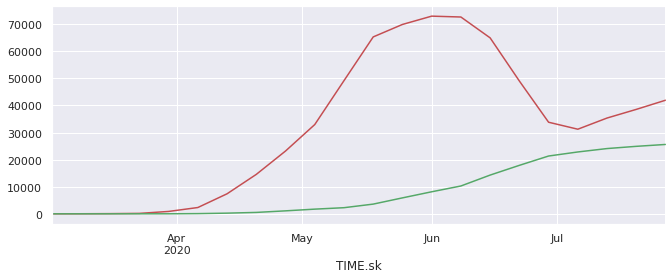

In [52]:
# Число больных
I = first_wave['ACTIVE.sk']
# Число невосприимчивых.
R = (first_wave['RECOVERED.sk']+first_wave['DEATHS.sk']).cumsum()
# Всего людей
N = 5384342
# Число восприимчивых
S = N - I - R

# В первую волну заболело только небольшое число жителей города, поэтому не будем выводить S. 
# S.plot(style='y') 
I.plot(style='r')
R.plot(style='g')
plt.show()

## Дополнительные вопросы для любопытных

1. Оцените эффективность введения локдауна весной 2020 года. Произведите сначала оценку на основе данных по смертности и заболеваемости. Затем проверьте вывод на основе данных Яндекс об индексе самоизоляции по регионам.

1. Оцените необходимую долю вакцинированного населения для достижения группового иммунитета весной 2020-го и летом 2021 (штам дельта).

1. Вычислите и сравните заразности штаммов COVID-19 в 2020 и в 2021 годах. Как изменилась смертность от COVID-19?

1. Доступные данные по-всей видимости содержат ошибки в сотни процентов. Как можно уменьшить ошибки? Какие выводы все-таки можно сделать?

1. Предположив некоторую модель отклонения числа заболеваний/смертей от скользящего среднего, используйте модель для оценки достоверности данных. Какие данные обладают признаками недостоверности? Чем это можно объяснить?

1. Попробуйте восстановить отсутствующие данные, построив математическую модель и натренировав ее на имеющихся данных. Оцените реальное число переболевших.

1. Оцените, насколько надежно данные о числе запросов про ковид в поисковых системах отражает реальное число заболеваний. Можно ли использовать данные о числе запросов для уточнения статистики?

1. Какие меры предложили бы вы для скорейшего завершения пандемии?

1. Швеция не вводила жесткий локдаун, но смертность в Швеции во время пандемии выросла слабо. Как вы можете это объяснить? Подкрепите свои выводы данными и моделированием.


